## Libraries

In [1]:
# !pip install ctgan
# !pip install table_evaluator

In [2]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import scipy

import matplotlib.pyplot  as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from datetime import datetime

import scipy.io

# for one-hot encoder
from sklearn.preprocessing import OneHotEncoder

# for feature extraction
from sklearn.decomposition import PCA

#MinMaxScaler
from sklearn import preprocessing

# anomalous model
from sklearn.ensemble import IsolationForest

# !pip install ctgan
# for synthetic data generation
# from ctgan import CTGAN

# !pip install table_evaluator
# for evaluation
# from table_evaluator import TableEvaluator

# Visualising multidimensional data in 2D plane
# reeducing dimension, it has similar effect as PCA
from sklearn.manifold import TSNE

## Import Data

In [3]:
csv_file = '2022-10-25 cdn_customer_qoe_anon.xlsx'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/DS_lab2/dataset/'+csv_file, 'cdn_customer_qoe_anon')

Mounted at /content/drive


In [5]:
# df = pd.read_excel('dataset/'+csv_file, 'cdn_customer_qoe_anon')

In [6]:
df_buffer = df.copy() 

In [7]:
df = df_buffer

In [8]:
df

,Column1,Start Time,Playtime,Effective Playtime,Interruptions,Join Time,Buffer Ratio,CDN Node Host,Connection Type,Device,...,End of Playback Status,User_ID_N,Title_N,Program_N,Device_Vendor_N,Device_Model_N,Content_TV_Show_N,Country_N,City_N,Region_N
0,0,2022-07-12 00:00:14,11,10,0,0.88,0.00,NaN,Ethernet-100,Android TV,...,On Stop,564,784,0,16,64,2672,3,263,0
1,1,2022-07-12 00:00:38,73,72,0,1.17,0.00,NaN,WiFi-5,Android TV,...,On Stop,480,1,0,13,63,2672,3,76,0
2,2,2022-07-12 00:02:02,21,20,0,1.13,0.00,NaN,WiFi-5,Android TV,...,On Stop,346,786,0,13,63,2672,3,76,0
3,3,2022-07-12 00:02:24,1,0,0,0.00,0.00,NaN,WiFi-5,Android TV,...,On Stop,346,997,0,13,63,2672,3,76,0
4,4,2022-07-12 00:02:25,1,0,0,0.00,0.00,NaN,WiFi-5,Android TV,...,On Stop,346,997,0,13,63,2672,3,76,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102251,102251,2022-07-25 23:06:05,15282,0,0,0.00,0.00,NaN,Mobile,iPhone,...,On Stop,570,1504,0,2,153,2434,3,367,0
102252,102252,2022-07-25 22:55:39,16582,16581,0,0.99,0.00,11377663,WiFi-5,Android TV,...,On Stop,475,1014,0,13,63,2672,3,39,0
102253,102253,2022-07-25 23:09:33,21166,0,0,0.00,0.00,NaN,WiFi-5,Android,...,On Stop,249,1076,0,16,41,2672,3,56,0
102254,102254,2022-07-25 11:47:37,65122,65115,2,6.10,0.00,NaN,None,PC( Windows ),...,On Stop,622,1437,0,8,158,694,3,56,0


In [9]:
# bringing the Numerical valued attributes names
# ====================================================
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df.select_dtypes(include=numerics).columns

## 19 columns

Index(['Column1', 'Playtime', 'Effective Playtime', 'Interruptions',
       'Join Time', 'Buffer Ratio', 'Happiness Score', 'Playback Stalls',
       'Startup Error (Count)', 'Latency', 'User_ID_N', 'Title_N', 'Program_N',
       'Device_Vendor_N', 'Device_Model_N', 'Content_TV_Show_N', 'Country_N',
       'City_N', 'Region_N'],
      dtype='object')

In [10]:
# bringing the Categorical object valued attributes names
# ====================================================
df.select_dtypes(include=['object']).columns

## 12 columns

Index(['CDN Node Host', 'Connection Type', 'Device', 'Device Type', 'Browser',
       'Browser Version', 'OS', 'OS Version', 'Device ID', 'Happiness Value',
       'Crash Status', 'End of Playback Status'],
      dtype='object')

In [11]:
# Date attributes names
# ====================================================

# ['Start Time, 'End Time']

## 2 columns

## Explore Data

### plot correlation matrix

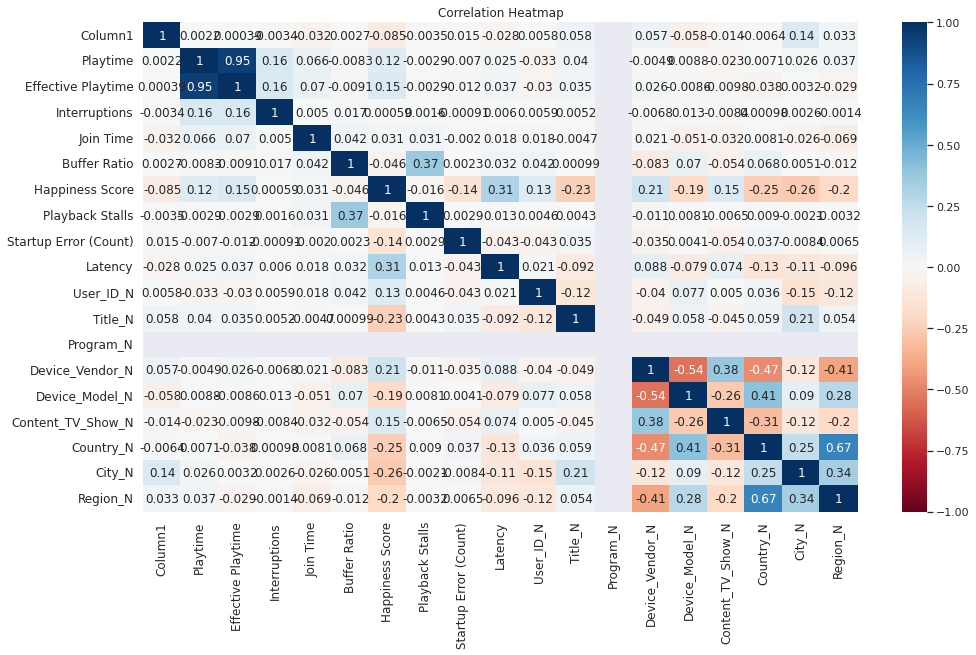

In [12]:
plt.figure(figsize = (16, 9))
s = sns.heatmap(df.corr(),
                annot = True,
                cmap = 'RdBu',
                vmin = -1,
                vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

In [13]:
df[['Start Time', 'End Time']]

# the time series is observed over the period of 2 weeks
# the difference between start time and end time almost fixed: 2 months and 22 days

,Start Time,End Time
0,2022-07-12 00:00:14,2022-10-04 00:00:26
1,2022-07-12 00:00:38,2022-10-04 00:01:52
2,2022-07-12 00:02:02,2022-10-04 00:02:24
3,2022-07-12 00:02:24,2022-10-04 00:02:26
4,2022-07-12 00:02:25,2022-10-04 00:02:28
...,...,...
102251,2022-07-25 23:06:05,2022-10-18 03:20:47
102252,2022-07-25 22:55:39,2022-10-18 03:32:02
102253,2022-07-25 23:09:33,2022-10-18 05:02:21
102254,2022-07-25 11:47:37,2022-10-18 05:53:00


In [14]:
df.describe()

,Column1,Playtime,Effective Playtime,Interruptions,Join Time,Buffer Ratio,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,Program_N,Device_Vendor_N,Device_Model_N,Content_TV_Show_N,Country_N,City_N,Region_N
count,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00
mean,51127.50,328.97,288.34,0.10,1.16,0.26,5.17,0.00,0.01,13360.82,392.98,809.66,0.00,13.13,69.46,2421.41,3.93,150.77,0.03
std,29518.91,1799.36,1697.49,12.01,2.84,3.57,4.38,0.20,0.12,23550.86,161.31,527.74,0.00,4.62,33.35,631.70,2.55,107.74,0.16
min,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,25563.75,4.00,1.00,0.00,0.58,0.00,0.00,0.00,0.00,0.00,295.00,261.00,0.00,13.00,63.00,2672.00,3.00,76.00,0.00
50%,51127.50,22.00,17.00,0.00,0.79,0.00,6.65,0.00,0.00,17862.00,383.00,997.00,0.00,15.00,64.00,2672.00,3.00,76.00,0.00
75%,76691.25,90.00,75.00,0.00,1.30,0.00,9.61,0.00,0.00,19235.00,487.00,1170.25,0.00,16.00,64.00,2672.00,3.00,240.00,0.00
max,102255.00,86404.00,86402.00,3786.00,120.00,100.00,10.00,44.41,1.00,359477.00,699.00,1638.00,0.00,24.00,163.00,2746.00,14.00,405.00,1.00


In [15]:
df['Buffer Ratio'].value_counts()

0.00      99621
100.00       17
0.01         11
0.01          9
0.01          8
          ...  
18.23         1
0.94          1
15.89         1
9.42          1
0.26          1
Name: Buffer Ratio, Length: 2076, dtype: int64

In [16]:
BR_EP = df[['Buffer Ratio', 'Effective Playtime']].copy()

In [17]:
df_buffer_ratio = BR_EP.groupby(['Buffer Ratio']).mean()

In [18]:
df_buffer_ratio = df_buffer_ratio.sort_values(by=['Buffer Ratio'], ascending=True)

In [19]:
df_buffer_ratio = df_buffer_ratio.reset_index()

In [20]:
df_buffer_ratio

,Buffer Ratio,Effective Playtime
0,0.00,257.49
1,0.00,25369.80
2,0.00,8790.60
3,0.00,11359.33
4,0.00,11358.43
...,...,...
2071,98.69,1.00
2072,98.84,3.00
2073,98.94,1.00
2074,99.00,2.00


In [21]:
print((df_buffer_ratio.columns))

Index(['Buffer Ratio', 'Effective Playtime'], dtype='object')


### QoE metrice effect on playtime

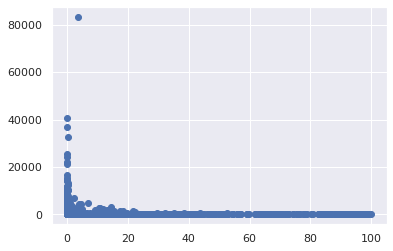

In [22]:
plt.plot( df_buffer_ratio["Buffer Ratio"],df_buffer_ratio["Effective Playtime"], 'bo')

In [23]:
# for better view
df_buffer_ratio_graph = df_buffer_ratio.loc[(df_buffer_ratio['Buffer Ratio'] < 40)]
df_buffer_ratio_graph = df_buffer_ratio.loc[(df_buffer_ratio['Effective Playtime'] < 8000)]

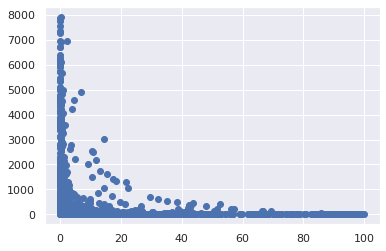

In [24]:
plt.plot( df_buffer_ratio_graph["Buffer Ratio"],df_buffer_ratio_graph["Effective Playtime"], 'bo')

it shows the effect of buffer ratio on the effective playing time

In [25]:
# null values
null_values = df.isnull().sum()
df_nulls = pd.DataFrame({'Column':null_values.index, 'Nulls':null_values.values})

# Count non empty cells
df_count = df_nulls
df_count = df_count.rename(columns={"Nulls": "Count"})
nb_rows = df.shape[0] # 102256
df_count.iloc[:,1] = nb_rows - df_count.iloc[:,1]

# count unique cells
uniqueValues = df.nunique()
df_unique = pd.DataFrame({'Column':uniqueValues.index, 'Unique':uniqueValues.values})


In [26]:
# merge all together in one dataframe
analyzed_df = pd.concat([df_nulls.iloc[:,0], df_count.iloc[:,1], df_nulls.iloc[:,1], df_unique.iloc[:,1]], axis = 1)
print(analyzed_df)

                    Column   Count   Nulls  Unique
0                  Column1  102256       0  102256
1               Start Time  102256       0   96503
2                 Playtime  102256       0    4752
3       Effective Playtime  102256       0    4440
4            Interruptions  102256       0      43
5                Join Time  102256       0    5554
6             Buffer Ratio  102256       0    2076
7            CDN Node Host   36979   65277     342
8          Connection Type  102256       0      19
9                   Device  102256       0      15
10             Device Type  102256       0      13
11                 Browser  102256       0      15
12         Browser Version  101411     845      64
13                      OS  102256       0       9
14              OS Version  102256       0      78
15               Device ID  102256       0    1692
16         Happiness Value  102255       1       5
17         Happiness Score  102256       0    6534
18         Playback Stalls  102

## Both are categorical: **1st** with strings, **2nd** with numbers, should do one-hot encoding except 'Happiness Score' because it is ordinal

'Connection Type', 'Device', 'Device Type', 'Browser', "Browser Version", 'OS', "OS Version", 'Crash Status', 'End of Playback Status'

'Device ID', 'Country_N', 'Region_N'

! 'Happiness Score' (will not)

! 'Content_TV_Show_N', will be removed due to high number of categories

In [27]:
df['Interruptions'].value_counts()

0       99615
1        1941
2         346
3         135
4          62
5          30
6          29
7          21
8          11
10          8
13          6
12          4
9           4
11          4
20          3
21          3
16          3
15          2
17          2
24          2
55          2
18          2
143         1
25          1
23          1
44          1
179         1
66          1
83          1
125         1
37          1
85          1
45          1
43          1
103         1
26          1
58          1
489         1
14          1
3786        1
27          1
30          1
188         1
Name: Interruptions, dtype: int64

In [28]:
# bringing the Numerical valued attributes names
# ====================================================
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df.select_dtypes(include=numerics).columns

## 19 columns

Index(['Column1', 'Playtime', 'Effective Playtime', 'Interruptions',
       'Join Time', 'Buffer Ratio', 'Happiness Score', 'Playback Stalls',
       'Startup Error (Count)', 'Latency', 'User_ID_N', 'Title_N', 'Program_N',
       'Device_Vendor_N', 'Device_Model_N', 'Content_TV_Show_N', 'Country_N',
       'City_N', 'Region_N'],
      dtype='object')

In [29]:
# bringing the Categorical object valued attributes names
# ====================================================
df.select_dtypes(include=['object']).columns

## 12 columns

Index(['CDN Node Host', 'Connection Type', 'Device', 'Device Type', 'Browser',
       'Browser Version', 'OS', 'OS Version', 'Device ID', 'Happiness Value',
       'Crash Status', 'End of Playback Status'],
      dtype='object')

## Data Cleaning

remove 'Column1'

In [30]:
df.drop(['Column1'], axis=1, inplace=True)

remove 'Program_N', it adds no value, all Zeros

In [31]:
df.drop(['Program_N'], axis=1, inplace=True)

remove 'Playtime' due to high correlation with 'Effective Playtime'

In [32]:
df.drop(['Playtime'], axis=1, inplace=True)

remove 'CDN Node Host' due to high percentage of missing values

In [33]:
df.drop(['CDN Node Host'], axis=1, inplace=True)

remove ' Happiness Value' as  Happiness score exists

In [34]:
df.drop(['Happiness Value'], axis=1, inplace=True)

remove 'Start Time', 'End Time'
Because this in this approuch will not use time series in ADetection 

In [35]:
df.drop(['Start Time'], axis=1, inplace=True)
df.drop(['End Time'], axis=1, inplace=True)

Removing 'Content_TV_Show_N' due to the high cardinality

In [36]:
df.drop(['Content_TV_Show_N'], axis=1, inplace=True)

Removing 'Device ID'

In [37]:
df.drop(['Device ID'], axis=1, inplace=True)

keeping the 'Crash Status' as the empty values means no crash happened

In [38]:
df['Crash Status'].value_counts()

Startup Error Crash      1276
In Stream Error Crash     569
Name: Crash Status, dtype: int64

# filling missing data

In [39]:
df['Browser Version'].fillna(df['Browser Version'].mode()[0], inplace = True)

In [40]:
df['Crash Status'] = df['Crash Status'].fillna('no crash')

In [41]:
df['End of Playback Status'].fillna(df['End of Playback Status'].mode()[0], inplace = True)

Some histogram plotting 

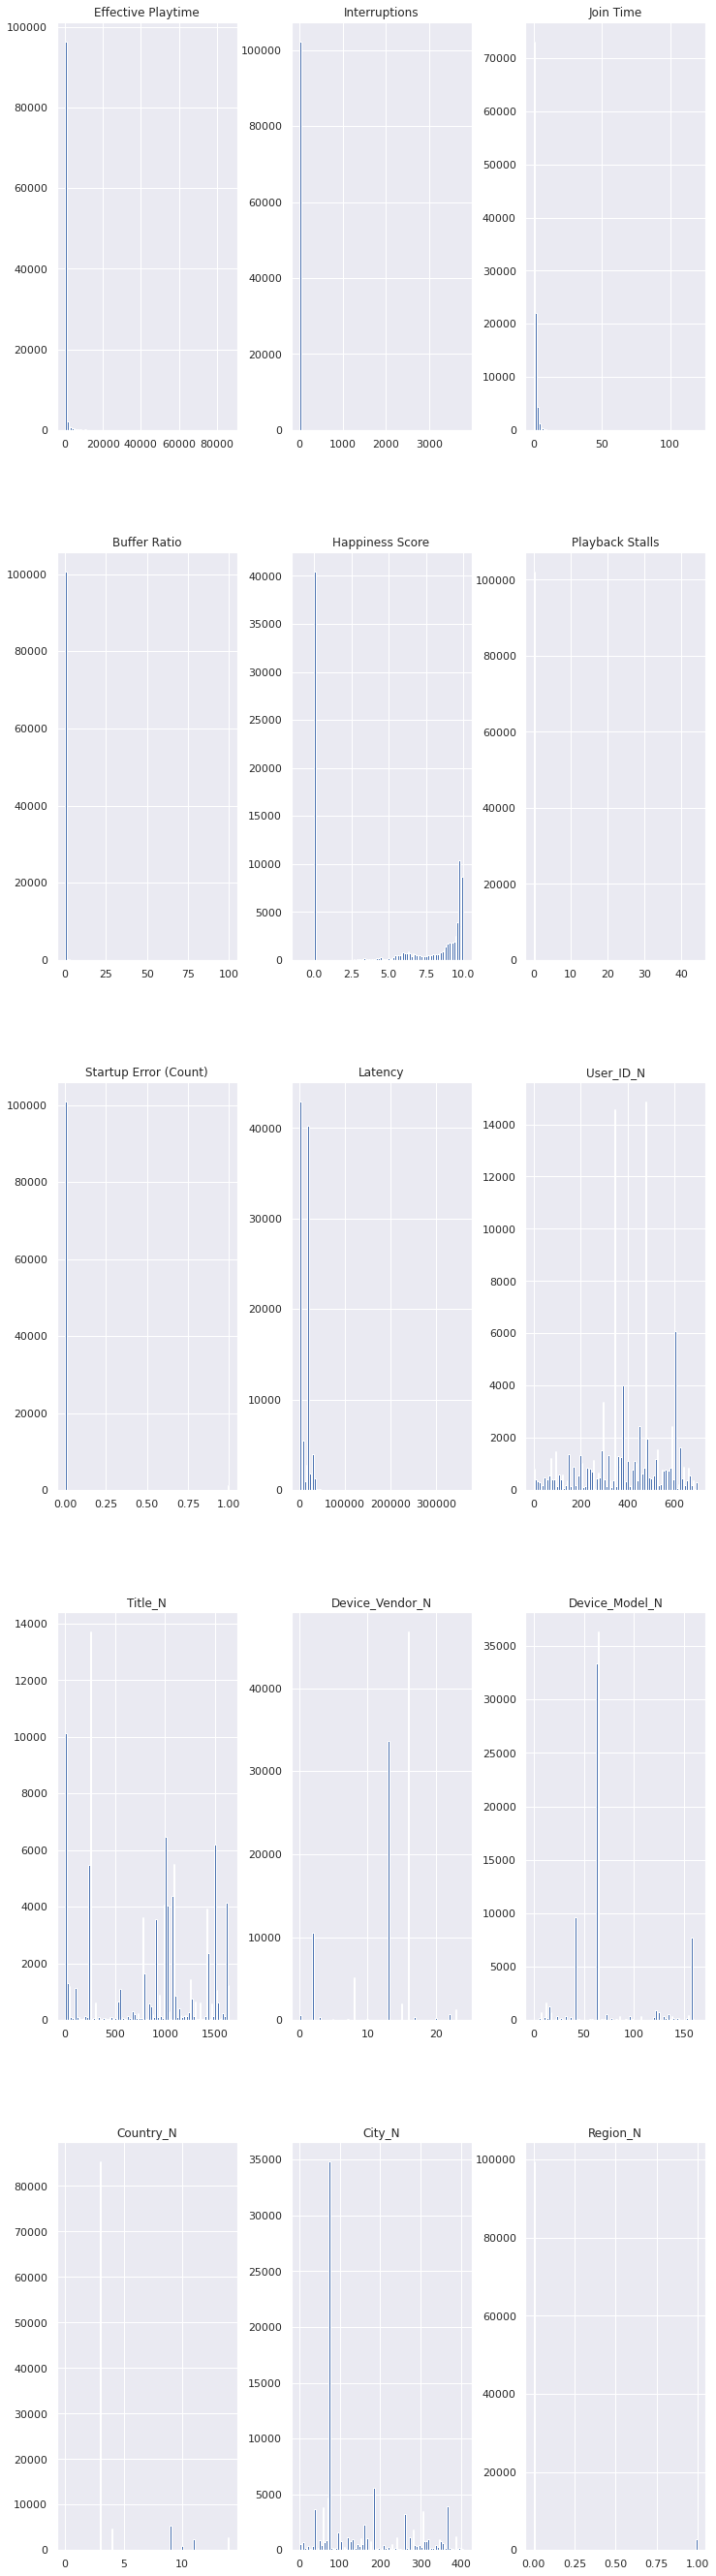

In [42]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numerical_fts = df.select_dtypes(include=numerics).columns

fig, axes = plt.subplots(len(df[df_numerical_fts].columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        df[df_numerical_fts].hist(column = df[df_numerical_fts].columns[i], bins = 100, ax=axis)
        i = i+1

# Milestone

In [43]:
# null values
null_values = df.isnull().sum()
df_nulls = pd.DataFrame({'Column':null_values.index, 'Nulls':null_values.values})

# Count non empty cells
df_count = df_nulls
df_count = df_count.rename(columns={"Nulls": "Count"})
nb_rows = df.shape[0] # 102256
df_count.iloc[:,1] = nb_rows - df_count.iloc[:,1]

# count unique cells
uniqueValues = df.nunique()
df_unique = pd.DataFrame({'Column':uniqueValues.index, 'Unique':uniqueValues.values})

In [44]:
# merge all together in one dataframe
analyzed_df = pd.concat([df_nulls.iloc[:,0], df_count.iloc[:,1], df_nulls.iloc[:,1], df_unique.iloc[:,1]], axis = 1)
print(analyzed_df)

                    Column   Count  Nulls  Unique
0       Effective Playtime  102256      0    4440
1            Interruptions  102256      0      43
2                Join Time  102256      0    5554
3             Buffer Ratio  102256      0    2076
4          Connection Type  102256      0      19
5                   Device  102256      0      15
6              Device Type  102256      0      13
7                  Browser  102256      0      15
8          Browser Version  102256      0      64
9                       OS  102256      0       9
10              OS Version  102256      0      78
11         Happiness Score  102256      0    6534
12         Playback Stalls  102256      0     425
13   Startup Error (Count)  102256      0       2
14                 Latency  102256      0   13416
15            Crash Status  102256      0       3
16  End of Playback Status  102256      0       4
17               User_ID_N  102256      0     700
18                 Title_N  102256      0    1639


In [45]:
df_2 = df.copy() 

In [46]:
# df = df_2

# One-hot Encoding

In [47]:
# to be encoded
df_categorical_fields_one_hot_encod = ['Connection Type', 'Device', 'Device Type', 'Browser', "Browser Version", 'OS', "OS Version", 'Crash Status', 'End of Playback Status', 'Country_N', 'Region_N']

In [48]:
df.shape

(102256, 24)

In [49]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

# One-hot-encode the categorical columns.
enc_package_type = pd.DataFrame(encoder.fit_transform(df[df_categorical_fields_one_hot_encod]).toarray())

#merge one-hot encoded columns back with original DataFrame
df = df_2.join(enc_package_type)

In [50]:
df.shape

(102256, 261)

In [51]:
# drop the features that was encoeded from
df.drop(df_categorical_fields_one_hot_encod, axis=1 ,inplace=True)

In [52]:
df.shape

(102256, 250)

In [53]:
df

,Effective Playtime,Interruptions,Join Time,Buffer Ratio,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,...,227,228,229,230,231,232,233,234,235,236
0,10,0,0.88,0.00,7.39,0.00,0,19504,564,784,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,72,0,1.17,0.00,9.40,0.00,0,19033,480,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,20,0,1.13,0.00,7.00,0.00,0,19071,346,786,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,0,0,0.00,0.00,0.00,0.00,0,0,346,997,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0,0,0.00,0.00,0.00,0.00,0,0,346,997,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102251,0,0,0.00,0.00,0.00,0.00,0,0,570,1504,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
102252,16581,0,0.99,0.00,10.00,0.00,0,18191,475,1014,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
102253,0,0,0.00,0.00,0.00,0.00,0,0,249,1076,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
102254,65115,2,6.10,0.00,7.46,0.00,0,27550,622,1437,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


# Milestone

In [54]:
df_3 = df.copy() 

## setup of anomalous detection

### min-max scaler for the model

In [55]:
# MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [56]:
df

,Effective Playtime,Interruptions,Join Time,Buffer Ratio,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,...,227,228,229,230,231,232,233,234,235,236
0,0.00,0.00,0.01,0.00,0.76,0.00,0.00,0.05,0.81,0.48,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,0.00,0.00,0.01,0.00,0.95,0.00,0.00,0.05,0.69,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,0.00,0.00,0.01,0.00,0.73,0.00,0.00,0.05,0.49,0.48,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.49,0.61,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.49,0.61,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102251,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.82,0.92,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
102252,0.19,0.00,0.01,0.00,1.00,0.00,0.00,0.05,0.68,0.62,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
102253,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.36,0.66,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
102254,0.75,0.00,0.05,0.00,0.77,0.00,0.00,0.08,0.89,0.88,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [57]:
model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=3, random_state=42, contamination=0.01)

In [58]:
model.fit(df)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


IsolationForest(contamination=0.01, max_features=3, n_estimators=200, n_jobs=-1,
                random_state=42)

In [59]:
df['Anomaly'] = pd.Series(model.predict(df))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [60]:
df.shape

(102256, 251)

In [61]:
df

,Effective Playtime,Interruptions,Join Time,Buffer Ratio,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,...,228,229,230,231,232,233,234,235,236,Anomaly
0,0.00,0.00,0.01,0.00,0.76,0.00,0.00,0.05,0.81,0.48,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1
1,0.00,0.00,0.01,0.00,0.95,0.00,0.00,0.05,0.69,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1
2,0.00,0.00,0.01,0.00,0.73,0.00,0.00,0.05,0.49,0.48,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1
3,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.49,0.61,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1
4,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.49,0.61,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102251,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.82,0.92,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1
102252,0.19,0.00,0.01,0.00,1.00,0.00,0.00,0.05,0.68,0.62,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1
102253,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.36,0.66,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1
102254,0.75,0.00,0.05,0.00,0.77,0.00,0.00,0.08,0.89,0.88,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1


In [62]:
# Labelling anomalous requests detected by Isolation Forest 
df['Anomaly'] = df['Anomaly'].map( {1: 0, -1: 1} )

In [63]:
df['Anomaly'].value_counts()

0    101233
1      1023
Name: Anomaly, dtype: int64

In [64]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=500, random_state=42)
tsne_results = tsne.fit_transform(df)
reduced_fts = np.array(tsne_results)


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [65]:
reduced_fts = pd.DataFrame(reduced_fts, columns = ['ft_one','ft_two'])

In [66]:
reduced_fts = pd.DataFrame(reduced_fts, columns = ['ft_one','ft_two'])

In [67]:
# add the output to the reduced features
reduced_fts['Anomaly'] = df['Anomaly']

In [ ]:
reduced_fts

,ft_one,ft_two,Anomaly
0,-2.82,-11.82,0
1,6.05,3.73,0
2,2.21,3.66,0
3,4.26,-11.95,0
4,4.26,-11.95,0
...,...,...,...
102251,12.56,15.80,0
102252,-4.34,4.72,0
102253,-4.55,12.45,0
102254,3.28,8.97,0


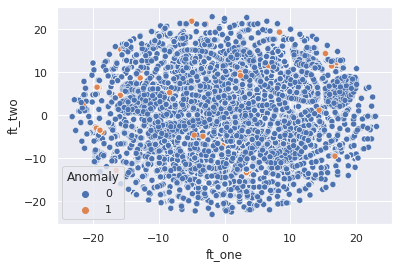

In [ ]:
# Scatterplot visualisation 
sns.scatterplot(
    x="ft_one", y="ft_two",
    hue="Anomaly",
    data= reduced_fts,
    legend="full",
    alpha=1
)

## Dispaly the properites of anomalous records


In [ ]:
df_buffer

,Effective Playtime,Interruptions,Join Time,Buffer Ratio,Connection Type,Device,Device Type,Browser,Browser Version,OS,...,Latency,Crash Status,End of Playback Status,User_ID_N,Title_N,Device_Vendor_N,Device_Model_N,Country_N,City_N,Region_N
0,10,0,0.88,0.00,Ethernet-100,Android TV,TV,Android Browser,Android Browser,Android,...,19504,no crash,On Stop,564,784,16,64,3,263,0
1,72,0,1.17,0.00,WiFi-5,Android TV,TV,Android Browser,Android Browser,Android,...,19033,no crash,On Stop,480,1,13,63,3,76,0
2,20,0,1.13,0.00,WiFi-5,Android TV,TV,Android Browser,Android Browser,Android,...,19071,no crash,On Stop,346,786,13,63,3,76,0
3,0,0,0.00,0.00,WiFi-5,Android TV,TV,Android Browser,Android Browser,Android,...,0,no crash,On Stop,346,997,13,63,3,76,0
4,0,0,0.00,0.00,WiFi-5,Android TV,TV,Android Browser,Android Browser,Android,...,0,no crash,On Stop,346,997,13,63,3,76,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102251,0,0,0.00,0.00,Mobile,iPhone,SmartPhone,Mobile Safari,Mobile Safari,iOS,...,0,no crash,On Stop,570,1504,2,153,3,367,0
102252,16581,0,0.99,0.00,WiFi-5,Android TV,TV,Android Browser,Android Browser,Android,...,18191,no crash,On Stop,475,1014,13,63,3,39,0
102253,0,0,0.00,0.00,WiFi-5,Android,STBAndroid,Android Browser,Android Browser,Android,...,0,no crash,On Stop,249,1076,16,41,3,56,0
102254,65115,2,6.10,0.00,None,PC( Windows ),PC,Chrome,Chrome 106.0.0.0,Windows,...,27550,no crash,On Stop,622,1437,8,158,3,56,0


In [116]:
df_2_all = df_2.copy()

In [117]:
df_2_all['Anomaly'] = df['Anomaly']
# df_2_all['Column1'] = df_buffer['Column1']

In [118]:
df_anom = df_2_all[df_2_all['Anomaly'] == 1]

In [119]:
df_buffer['Interruptions'].value_counts()
# df_buffer['Country_N'].value_counts()

0       99615
1        1941
2         346
3         135
4          62
5          30
6          29
7          21
8          11
10          8
13          6
12          4
9           4
11          4
20          3
21          3
16          3
15          2
17          2
24          2
55          2
18          2
143         1
25          1
23          1
44          1
179         1
66          1
83          1
125         1
37          1
85          1
45          1
43          1
103         1
26          1
58          1
489         1
14          1
3786        1
27          1
30          1
188         1
Name: Interruptions, dtype: int64

In [120]:
df_anom['Interruptions'].value_counts()
# df_anom['Country_N'].value_counts()

1      737
2      114
3       50
0       40
4       24
5       16
6       11
7        9
8        4
13       3
10       2
83       1
15       1
18       1
16       1
21       1
14       1
24       1
26       1
125      1
11       1
27       1
30       1
17       1
Name: Interruptions, dtype: int64

In [ ]:
df_anom.describe()

,Effective Playtime,Interruptions,Join Time,Buffer Ratio,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,Device_Vendor_N,Device_Model_N,Country_N,City_N,Region_N,Anomaly
count,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00
mean,415.20,1.89,2.19,13.99,3.89,0.13,0.04,22021.60,449.17,842.95,9.08,82.54,6.03,224.75,0.02,1.00
std,1762.61,5.22,3.14,24.22,2.54,0.24,0.19,44581.09,181.41,529.10,6.10,60.68,3.66,125.08,0.14,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,1.00,0.00,8.00,2.00,0.00,0.00,1.00
25%,6.00,1.00,0.79,0.87,1.51,0.01,0.00,0.00,345.00,261.00,2.00,26.00,3.00,76.00,0.00,1.00
50%,25.00,1.00,1.51,3.64,4.25,0.03,0.00,0.00,438.00,934.00,8.00,72.00,4.00,244.00,0.00,1.00
75%,130.50,1.00,2.78,12.66,5.84,0.10,0.00,31748.50,589.00,1412.00,15.00,158.00,11.00,348.00,0.00,1.00
max,26337.00,125.00,36.41,100.00,7.98,1.22,1.00,333214.00,699.00,1638.00,22.00,158.00,14.00,405.00,1.00,1.00


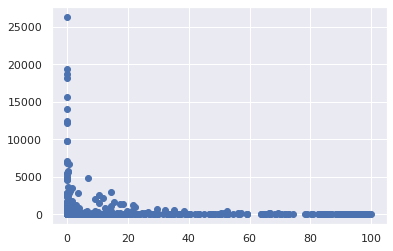

In [ ]:
plt.plot( df_anom["Buffer Ratio"],df_anom["Effective Playtime"], 'bo')

Statisitcal analysis:
--------------------
anomaly = 1023;
normal = 101233;

anomaly % = (anomaly/(anomaly + normal)) * 100 = (1023/102256) * 100 = 1.00043 ~ 1 %

#########



#########

# Synthetic data gerneration
in this task, two spereate sets of data will be generated: **anomalous** and **non-anomalous** .

Note: theb data generated is the usfeull, meaningfull data after cleaning and preprocessing that wil be usefull for the model

In [121]:
original_set = df_2.copy()

In [122]:
original_set['Anomaly'] = df['Anomaly']

In [123]:
original_set_without_anom = original_set.loc[original_set['Anomaly'] == 0]
original_set_with_anom = original_set.loc[original_set['Anomaly'] == 1]

prepare fields for the model

In [ ]:
# Names of the columns that are discrete
discrete_columns =  [
    'Connection Type', 
    'Device', 
    'Device Type', 
    'Browser', 
    'Browser Version', 
    'OS', 
    'OS Version', 
    'Crash Status', 
    'End of Playback Status', 
    'Country_N', 
    'Region_N'
    ]

In [ ]:
print(original_set_without_anom.columns[0:8])

Index(['Effective Playtime', 'Interruptions', 'Join Time', 'Buffer Ratio',
       'Connection Type', 'Device', 'Device Type', 'Browser'],
      dtype='object')


In [ ]:
print(original_set_without_anom.columns[8:16])

Index(['Browser Version', 'OS', 'OS Version', 'Happiness Score',
       'Playback Stalls', 'Startup Error (Count)', 'Latency', 'Crash Status'],
      dtype='object')


In [ ]:
original_set_without_anom

In [ ]:
# ctgan = CTGAN(epochs=6)
# ctgan.fit(original_set_without_anom, discrete_columns)

# # Create synthetic data
# synthetic_data_without_anom = ctgan.sample(148500)

In [ ]:
# ctgan.save('CTGAN_model.pkl')
loaded = CTGAN.load('CTGAN_model.pkl')
synthetic_data_without_anom = loaded.sample(9900)

In [ ]:
# ctgan_anom = CTGAN(epochs=15)
# ctgan_anom.fit(original_set_with_anom, discrete_columns)

# # Create synthetic data
# synthetic_data_with_anom = ctgan_anom.sample(1500)

In [ ]:
# ctgan_anom.save('CTGAN_model_anom.pkl')

In [ ]:
ctgan_anom = CTGAN.load('CTGAN_model_anom.pkl')
synthetic_data_with_anom = ctgan_anom.sample(100)

## Add data to each other

In [ ]:
synthetic_data = synthetic_data_without_anom.append(synthetic_data_with_anom, ignore_index=True)

# for testing similarity

## in the whole features (normal)

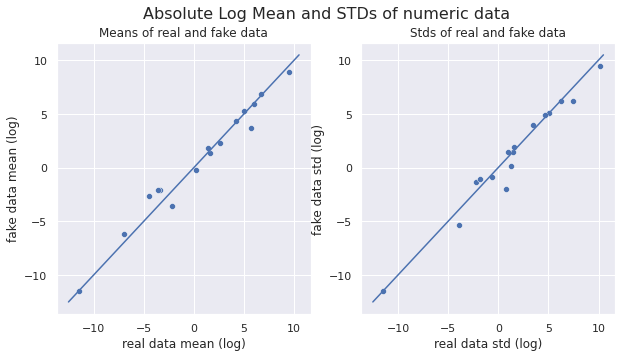

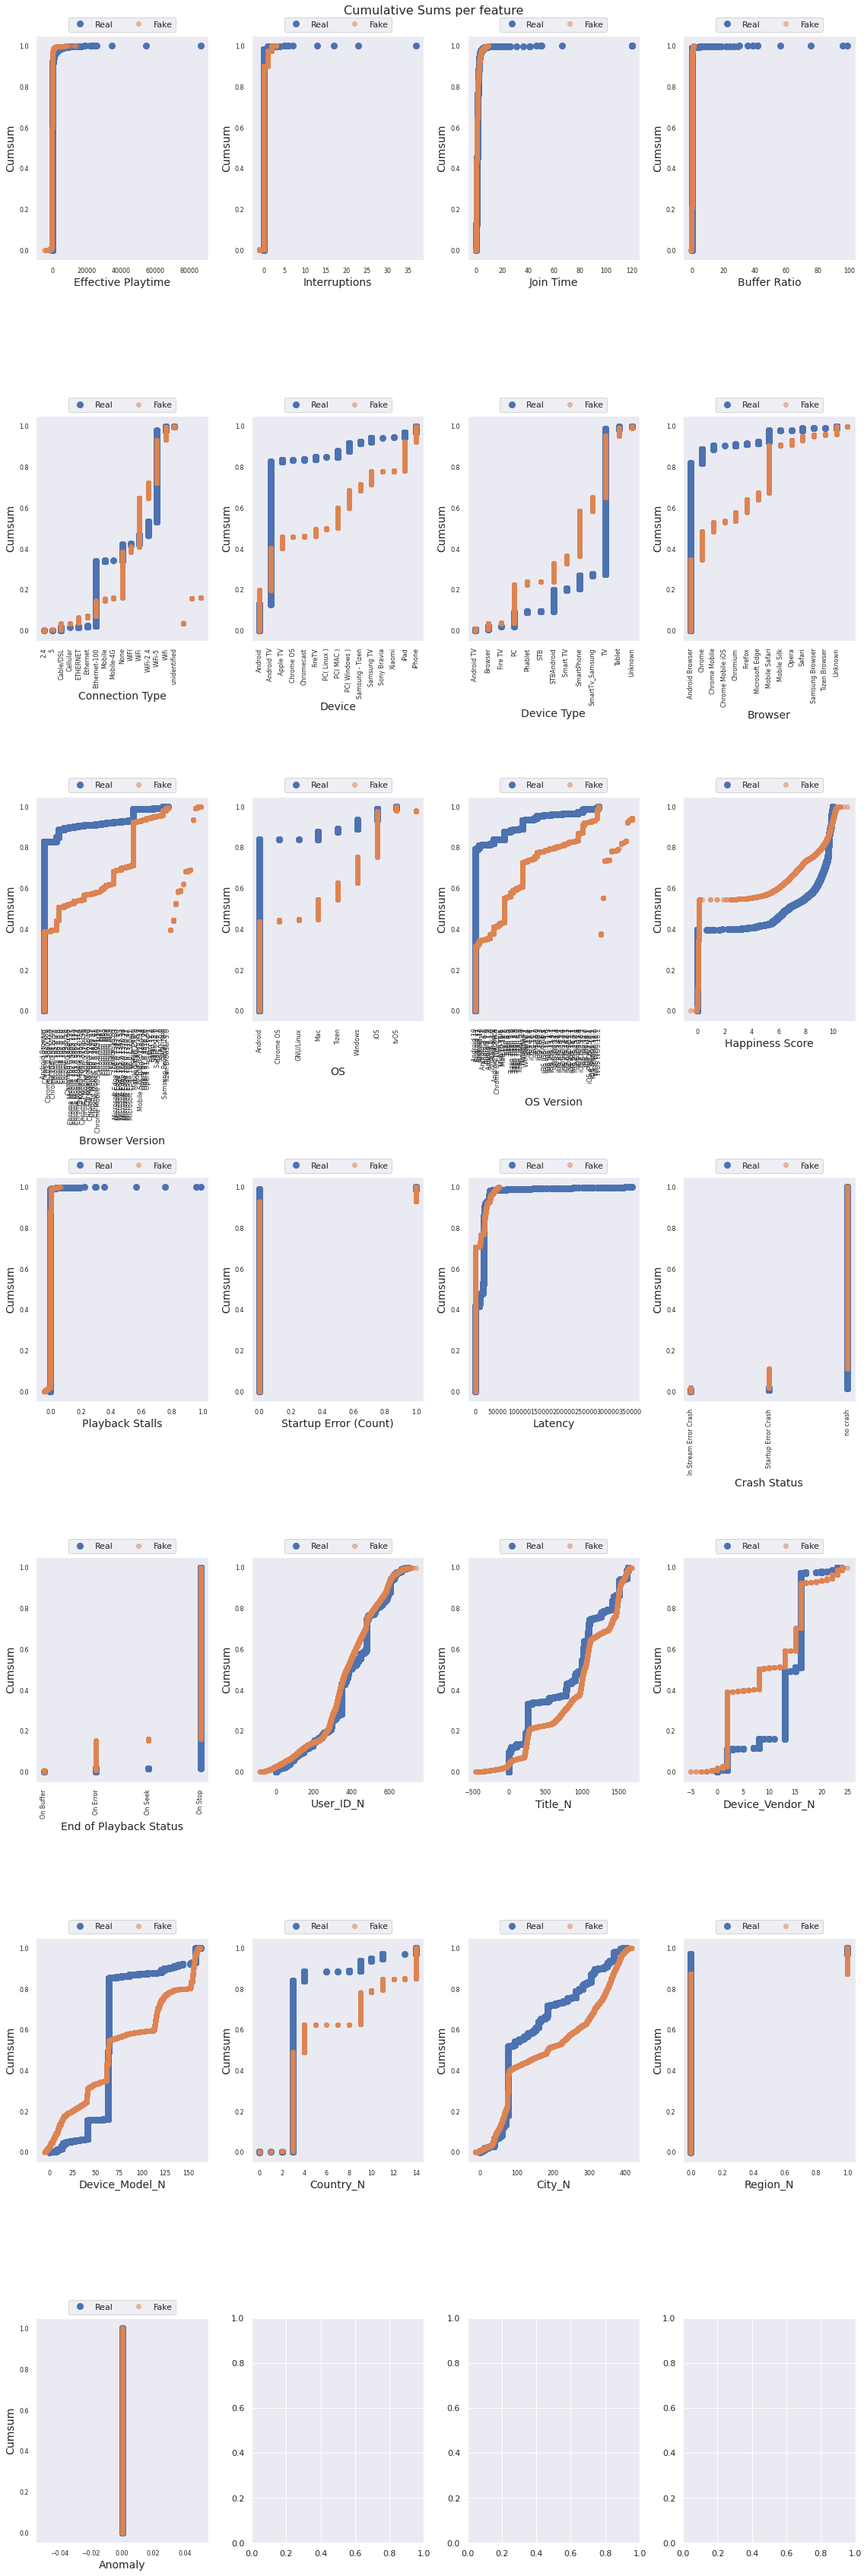

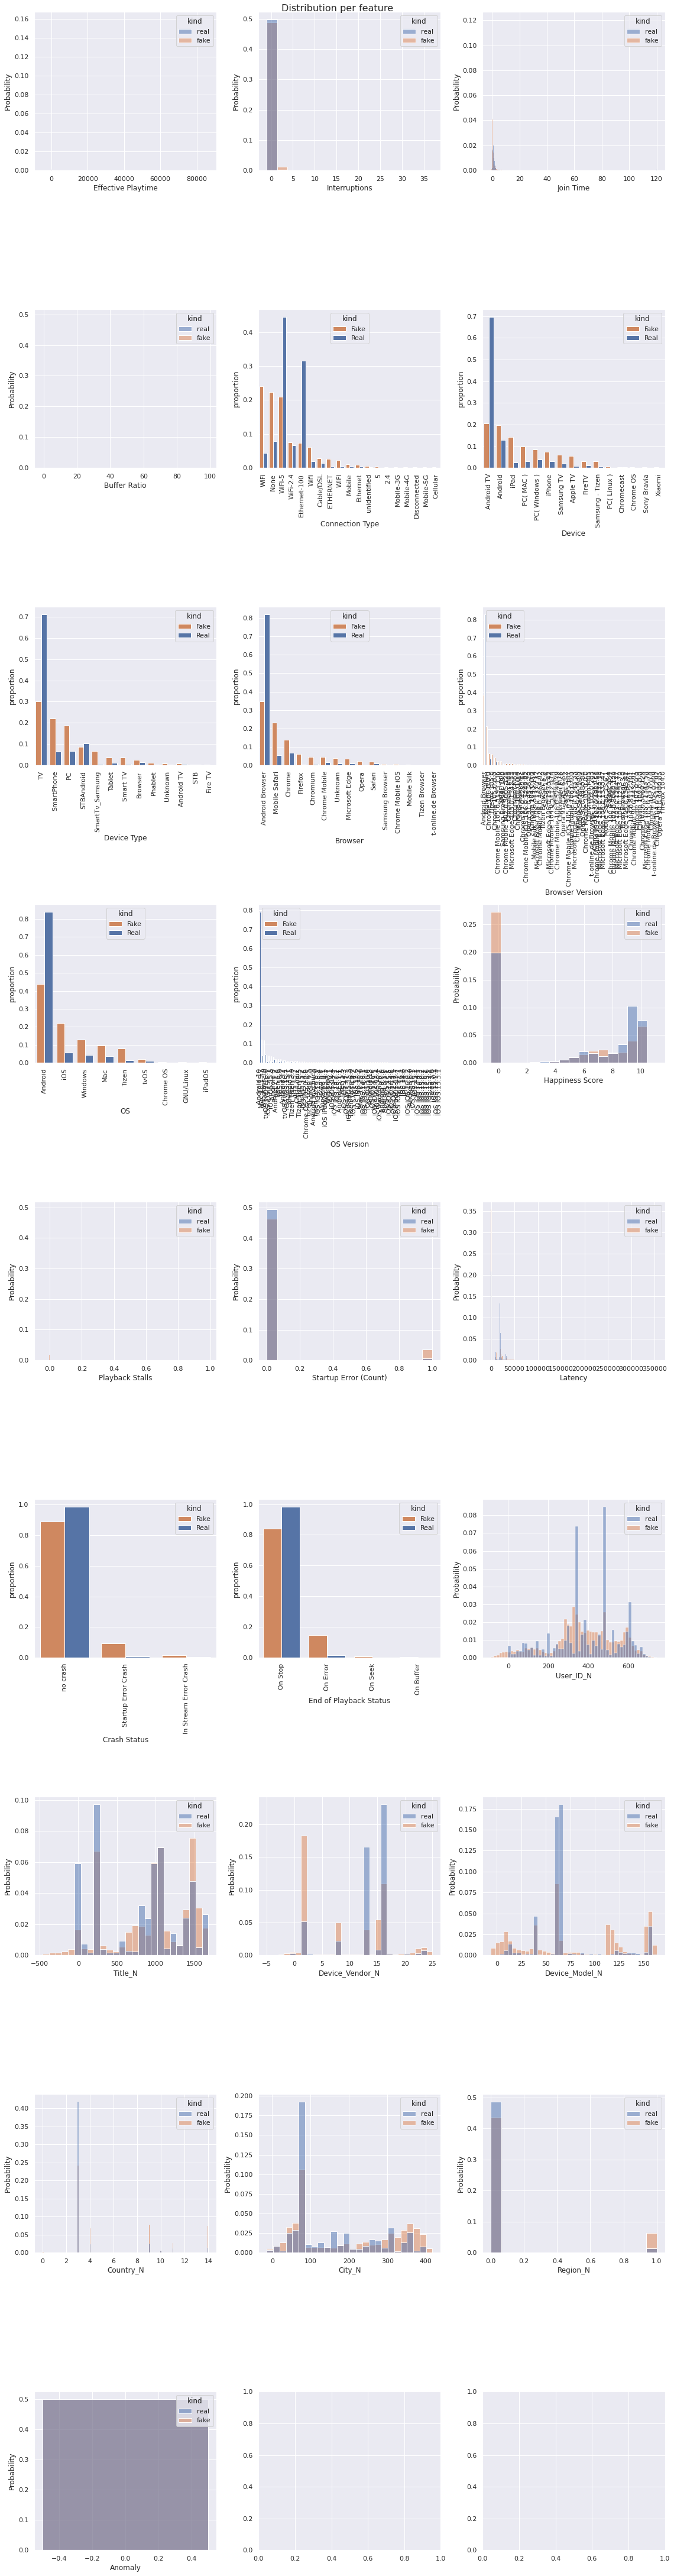

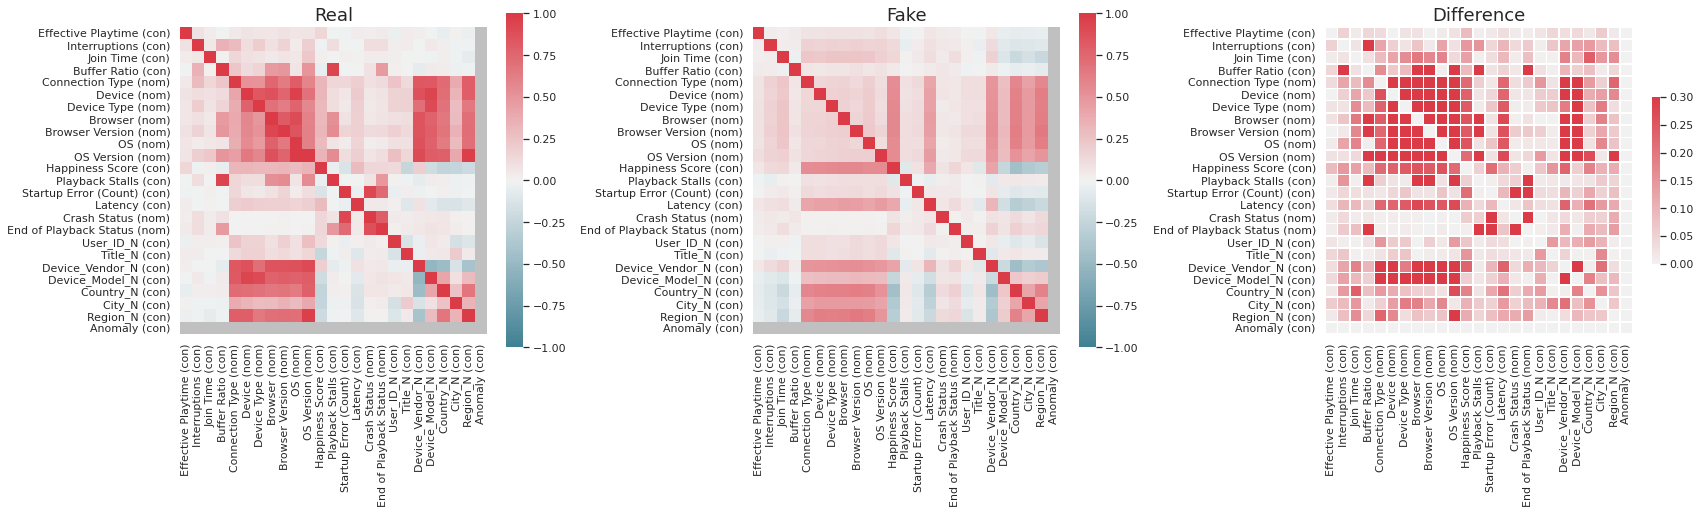

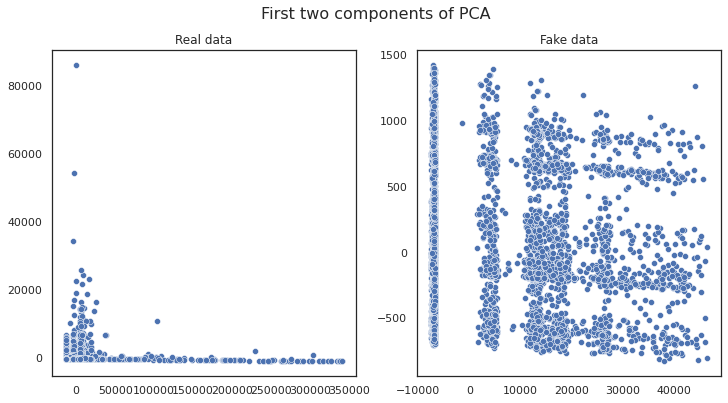

In [ ]:
table_evaluator = TableEvaluator(original_set_without_anom, synthetic_data_without_anom)
table_evaluator.visual_evaluation()

## in the specific feature (normal)

In [ ]:
table_evaluator.evaluate(target_col='Effective Playtime')

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())



Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.0096   0.0182              0.0056
DecisionTreeClassifier_real   0.3657   0.0040              0.0013
LogisticRegression_fake       0.0096   0.0293              0.0000
LogisticRegression_real       0.2338   0.0000              0.0000
MLPClassifier_fake            0.0051   0.0157              0.0010
MLPClassifier_real            0.2414   0.0000              0.0005
RandomForestClassifier_fake   0.0136   0.0177              0.0035
RandomForestClassifier_real   0.3818   0.0056              0.0028

Privacy results:
                                           result
Duplicate rows between sets (real/fake)  (509, 0)
nearest neighbor mean                      2.2559
nearest neighbor std                       1.7404

Miscellaneous results:
                                  Result
Co

## in the whole features (anomalous)

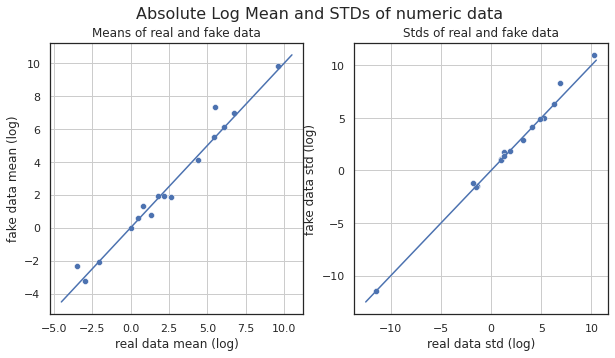

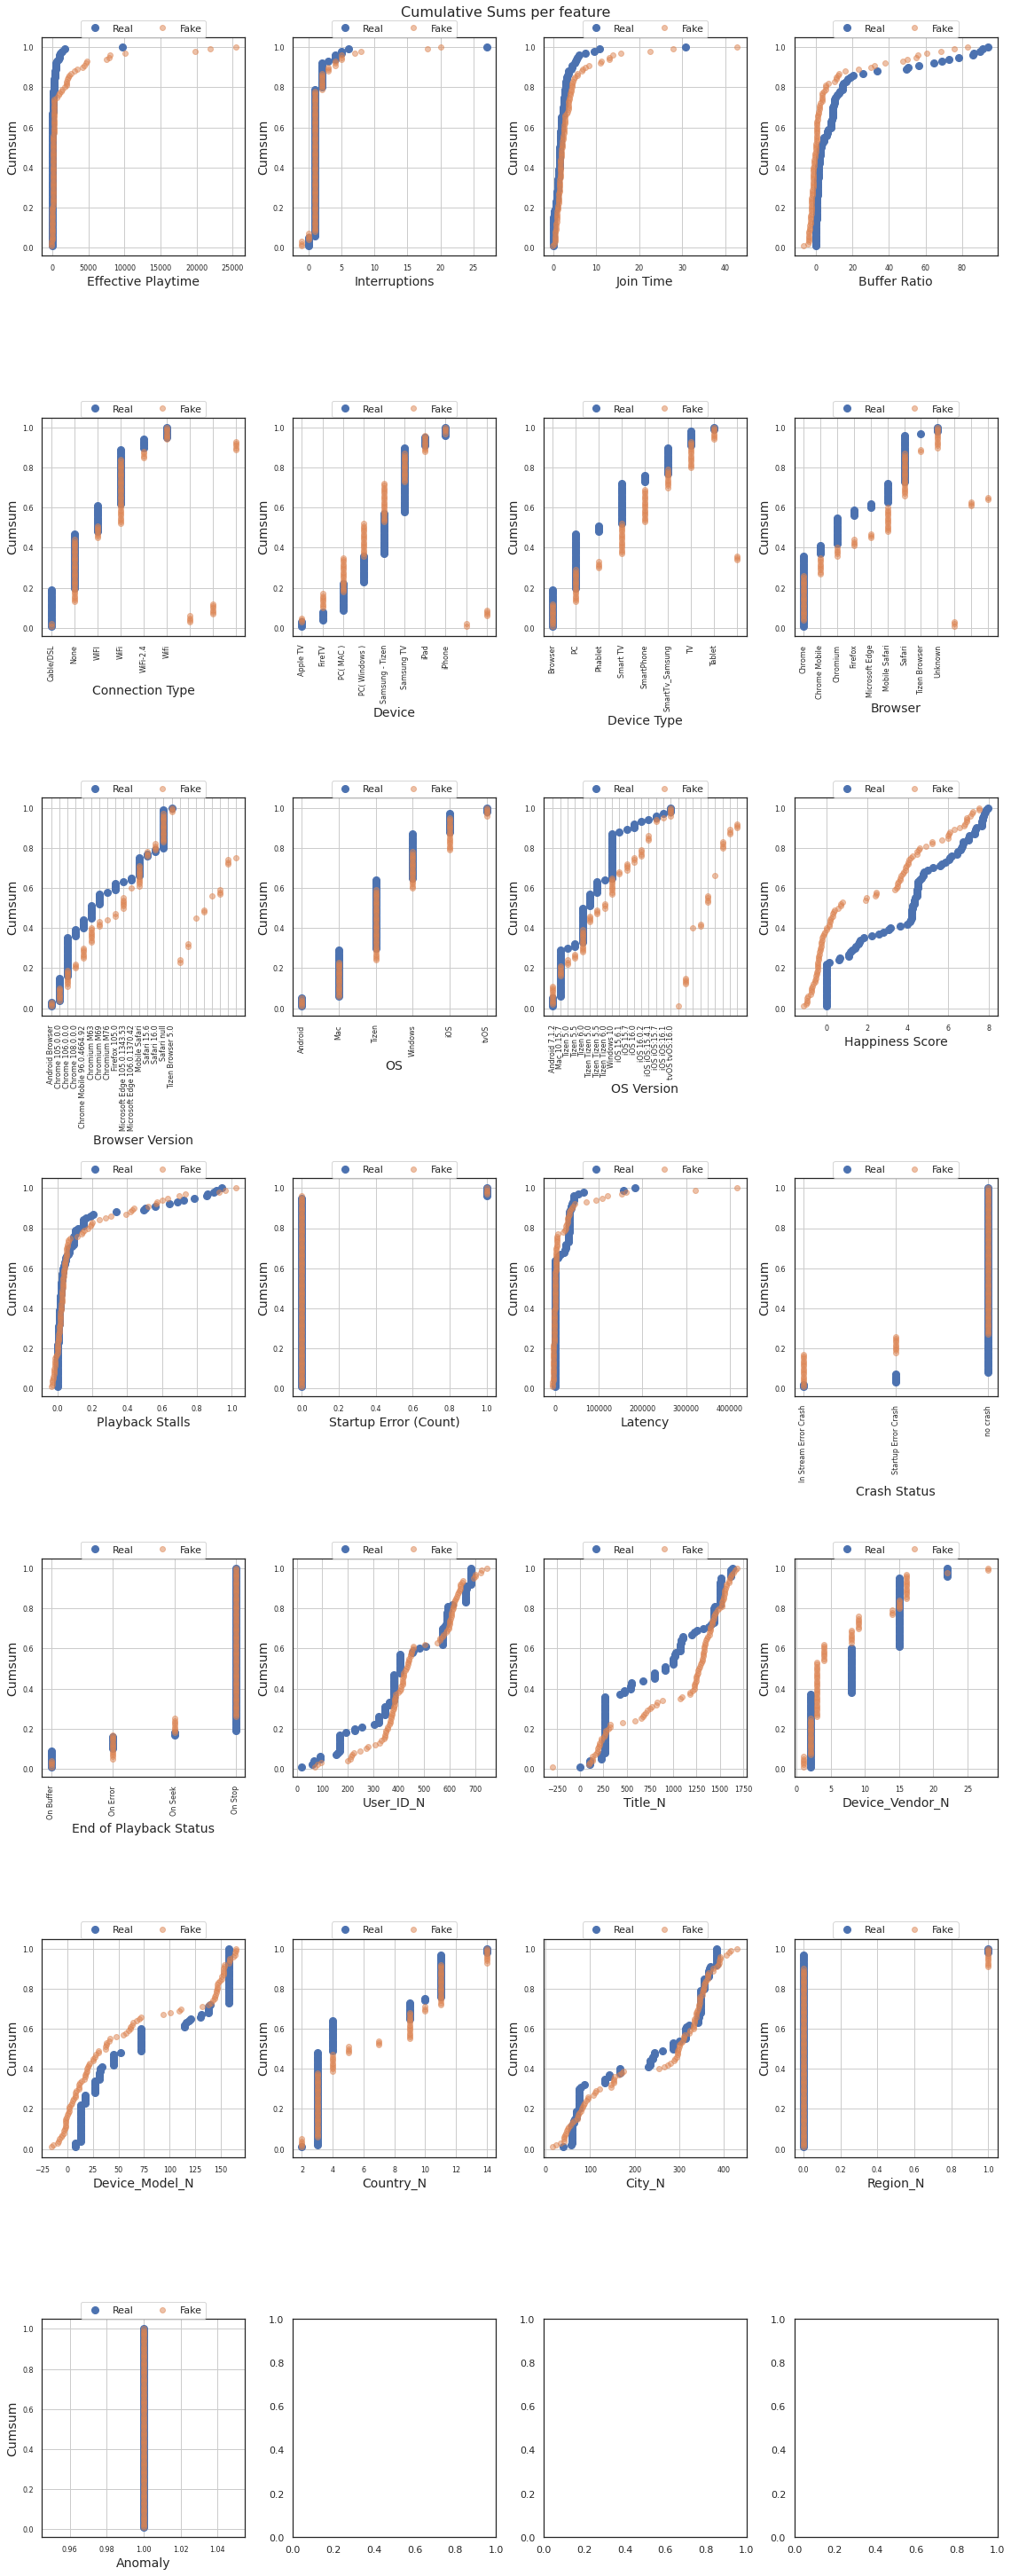

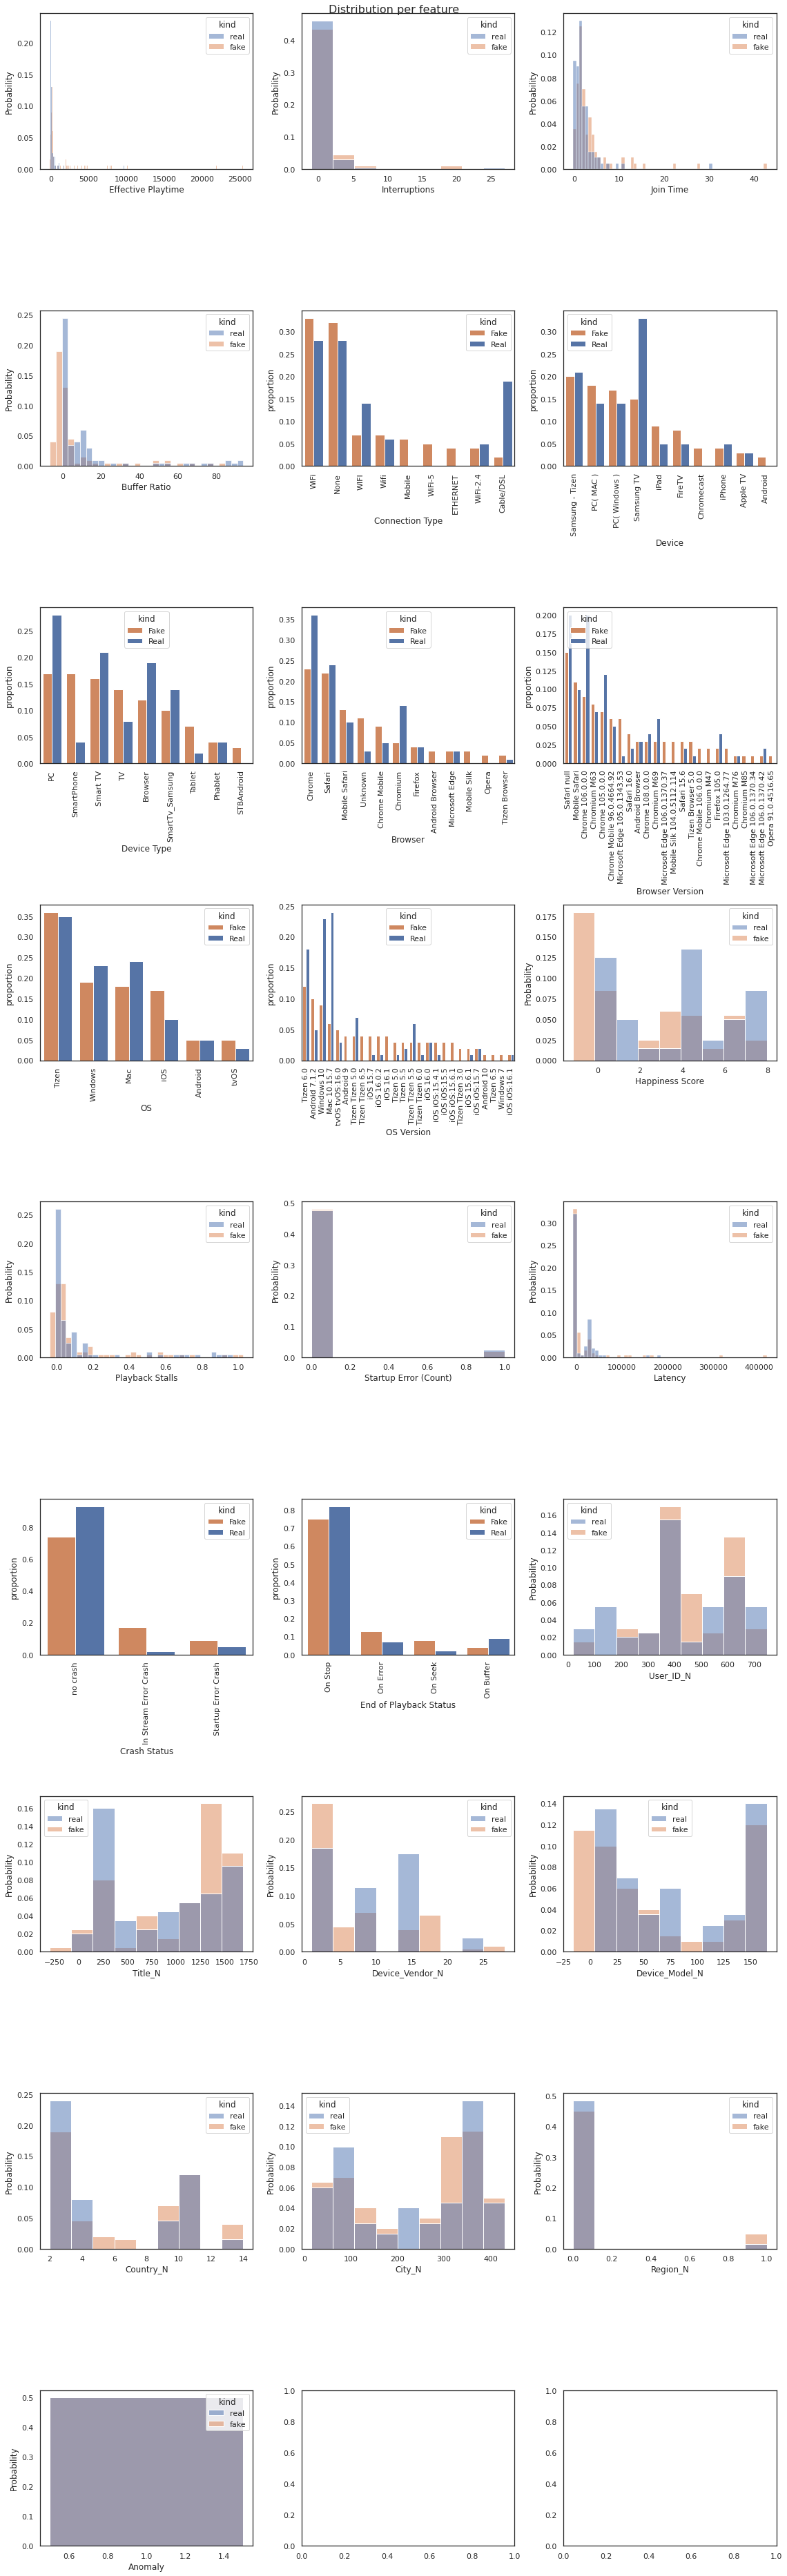

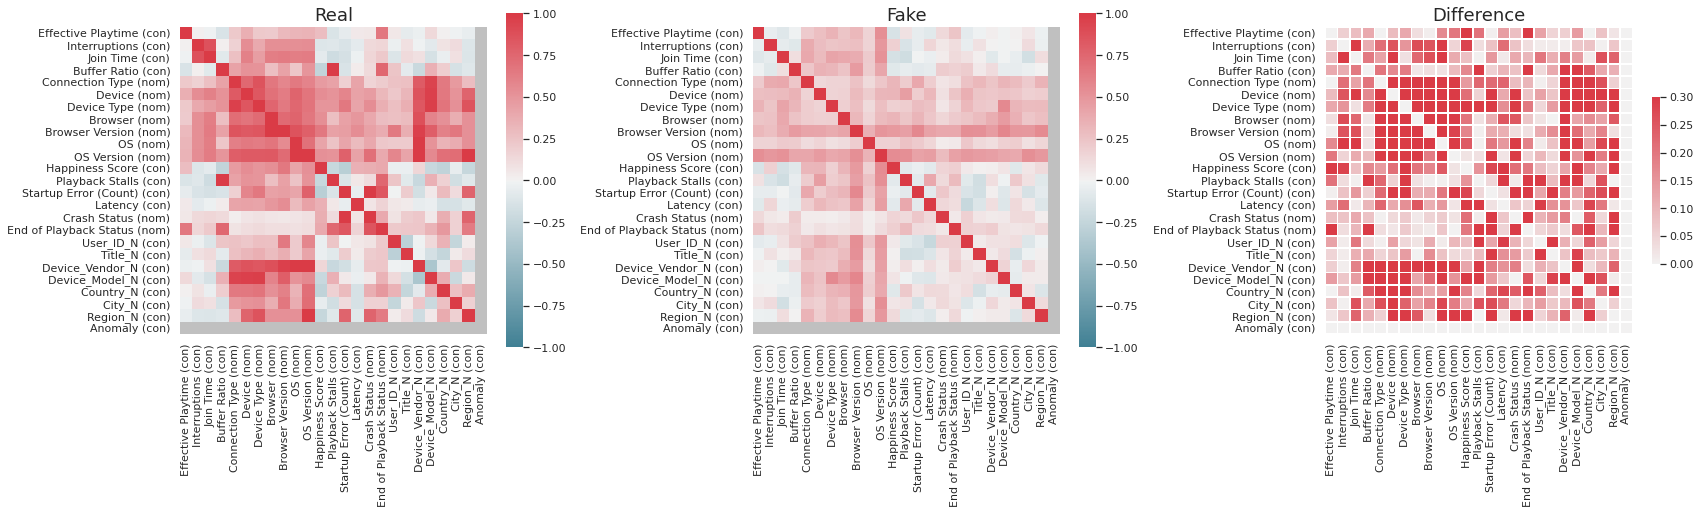

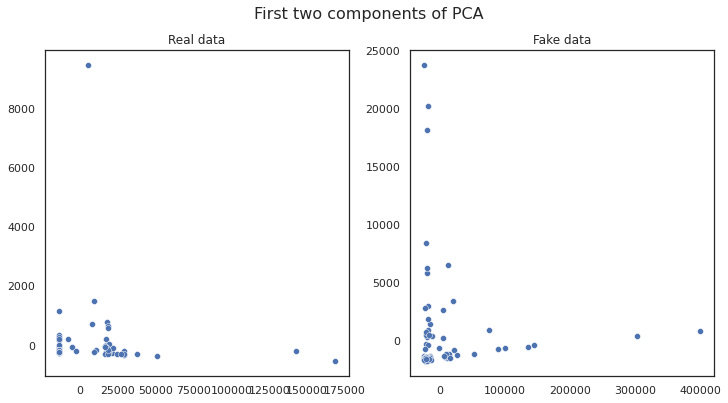

In [ ]:
table_evaluator_anom = TableEvaluator(original_set_with_anom, synthetic_data_with_anom)
table_evaluator_anom.visual_evaluation()

## in the specific feature (anomalous)

In [ ]:
table_evaluator_anom.evaluate(target_col='Effective Playtime')

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/dist-packages/table_evaluator/metrics.py:42: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true))



Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.0000   0.0000              0.0000
DecisionTreeClassifier_real   0.1000   0.1000              0.0526
LogisticRegression_fake       0.0000   0.0000              0.0000
LogisticRegression_real       0.0500   0.0000              0.0000
MLPClassifier_fake            0.0000   0.0000              0.0000
MLPClassifier_real            0.0500   0.0000              0.0000
RandomForestClassifier_fake   0.0000   0.0000              0.0256
RandomForestClassifier_real   0.1000   0.0000              0.0000

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    4.1581
nearest neighbor std                     0.8943

Miscellaneous results:
                                  Result
Column Cor